# **Community Detection**
----

### 1. Environment Setup
Click on the button below to open the notebook in Google Colab and run the following commands to install the required libraries.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hardness1020/Community_Detection/blob/main/main.ipynb)

In [ ]:
!git clone https://github.com/hardness1020/Community_Detection.git

In [ ]:
# For colab
%cd Community_Detection
%pip install -r requirements.txt
!git clone https://github.com/6lyc/CDNMF.git

# For local
# %pip install -r requirements.txt
!git clone https://github.com/6lyc/CDNMF.git

In [ ]:
# Import packages
import os
import random
import numpy as np
import pandas as pd
import linecache
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics.cluster import normalized_mutual_info_score, \
    adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
from CDNMF.Utils.evaluate import clusterscores
from CDNMF.Dataset.dataset import Dataset
from CDNMF.Model.my_model import Model
from CDNMF.PreTrainer.pretrainer import PreTrainer
from CDNMF.Utils import gpu_info

# Check GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

### 2. Methods

#### 2.1. Spactral Clustering Method

#### 2.2. CDNMF Method
- Recommended to use GPU for faster computation.
- The output of prediction was stored in 'prediction/CDNMF_example.csv'.
- The format of the output file is as follows:
    - Each row represents the category of the corresponding node.

In [ ]:
# Set config

random.seed(42)

dataset_config = {'feature_file': './dataset/cora/features.txt',
                  'graph_file': './dataset/cora/edges.txt',
                  'walks_file': './dataset/cora/walks.txt',
                  'label_file': './dataset/cora/group.txt',
                  'device': device}
graph = Dataset(dataset_config)

pretrain_config = {
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'seed': 42,
    'pre_iterations': 100,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl'}

model_config = {
    'device': device,
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'is_init': True,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl',
    'tau': 1.3,
    'conc': 5,
    'negc': 400,
    'rec': 1,
    'r': 3,
    'learning_rate': 0.01,
    'weight_decay': 0.00001,
    'epoch': 550,
    'run': 20,
    'model_path': './CDNMF/Log/cora/cora_model.pkl'
}

In [ ]:
# Train model

# Load pretrain params
model = Model(model_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['learning_rate'])
    
# Train model
for epoch in tqdm(range(model_config['epoch'])):
    optimizer.zero_grad()
    V = model()

    loss, loss1, loss2, loss3, loss4, loss5 = model.loss(graph)
    loss.backward()
    optimizer.step()
        
# Write y_pred to file
pred_dir = f'./prediction/'
y_pred = np.argmax(V.detach().cpu().numpy(), axis=0)
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
with open(f'{pred_dir}CDNMF.txt', 'w') as f:
    for i in y_pred:
        f.write(str(i) + '\n')

<!-- ### 3. Evaluation -->

### 3. Evaluation

In [ ]:
# Load prediction and ground truth files

# Set the path to the prediction file. 
# By default, the example prediction file is used. 
# Use the other path if running the CDNMF model.

CDNMF_path = 'prediction/CDNMF_example.txt'
# CDNMF_path = 'prediction/CDNMF.txt'

y_pred_CDNMF = pd.read_csv(CDNMF_path, header=None).values[:, 0]
y_true = pd.read_csv('dataset/cora/group.txt', header=None, delimiter=' ').values[:, 1]

#### 3.1. Evaluation Metrics
- **Accuracy**: A ratio of the number of correctly classified samples to the total number of samples.
- **Normalized Mutual Information (NMI)**: A measure of the similarity between two clusterings of a set of data. It is often used to assess the quality of clusters created by an algorithm against some ground truth. 
- **Adjusted Rand Index (ARI)**: A measure of the similarity between two data clusterings. It considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusterings.
- **Adjusted Mutual Information (AMI)**: A measure of the agreement between two clusterings of the same data. It measures the amount of information obtained about one clustering by knowing another.


In [ ]:


def cluster_acc(y_pred, y_true):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max().astype(int), y_true.max().astype(int)) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = sklearn.utils.linear_assignment_.linear_assignment(w.max() - w)
    # row_ind, col_ind = linear_assignment(w.max() - w)
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

def clusterscores(pred: np.array, target: np.array):
    ACC = cluster_acc(pred, target)
    NMI = normalized_mutual_info_score(target, pred)
    ARI = adjusted_rand_score(target, pred)
    AMI = adjusted_mutual_info_score(target, pred)
    return {'ACC': ACC, 'NMI': NMI, 'ARI': ARI, 'AMI': AMI}

In [ ]:
scores_CDNMF = clusterscores(y_pred_CDNMF, y_true)
scores_CDNMF

{'ACC': 0.6144756277695717,
 'NMI': 0.3980022280364673,
 'ARI': 0.38495332353352185,
 'AMI': 0.39573388733062054}

#### 3.2. Visualization

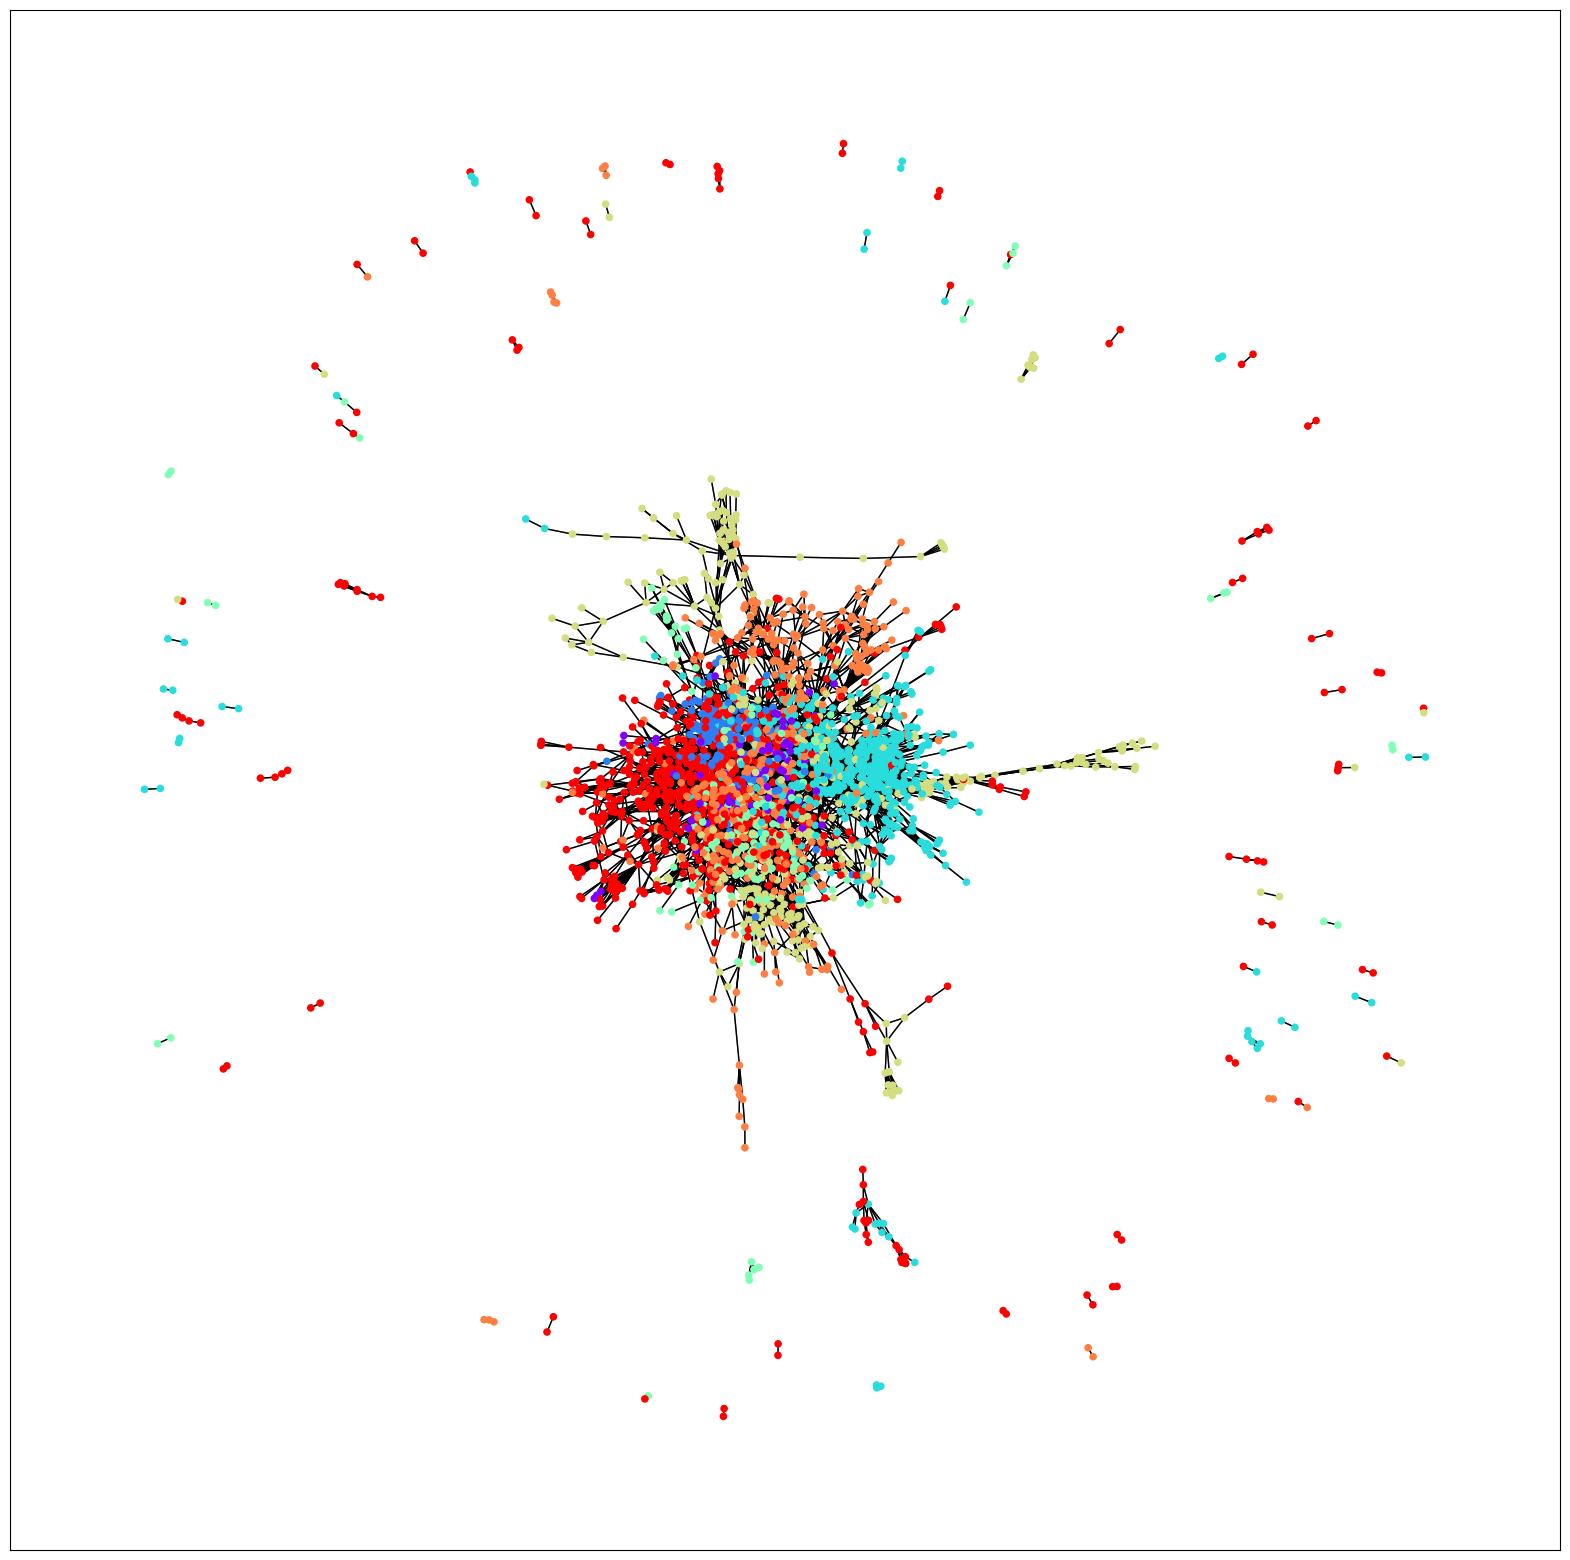

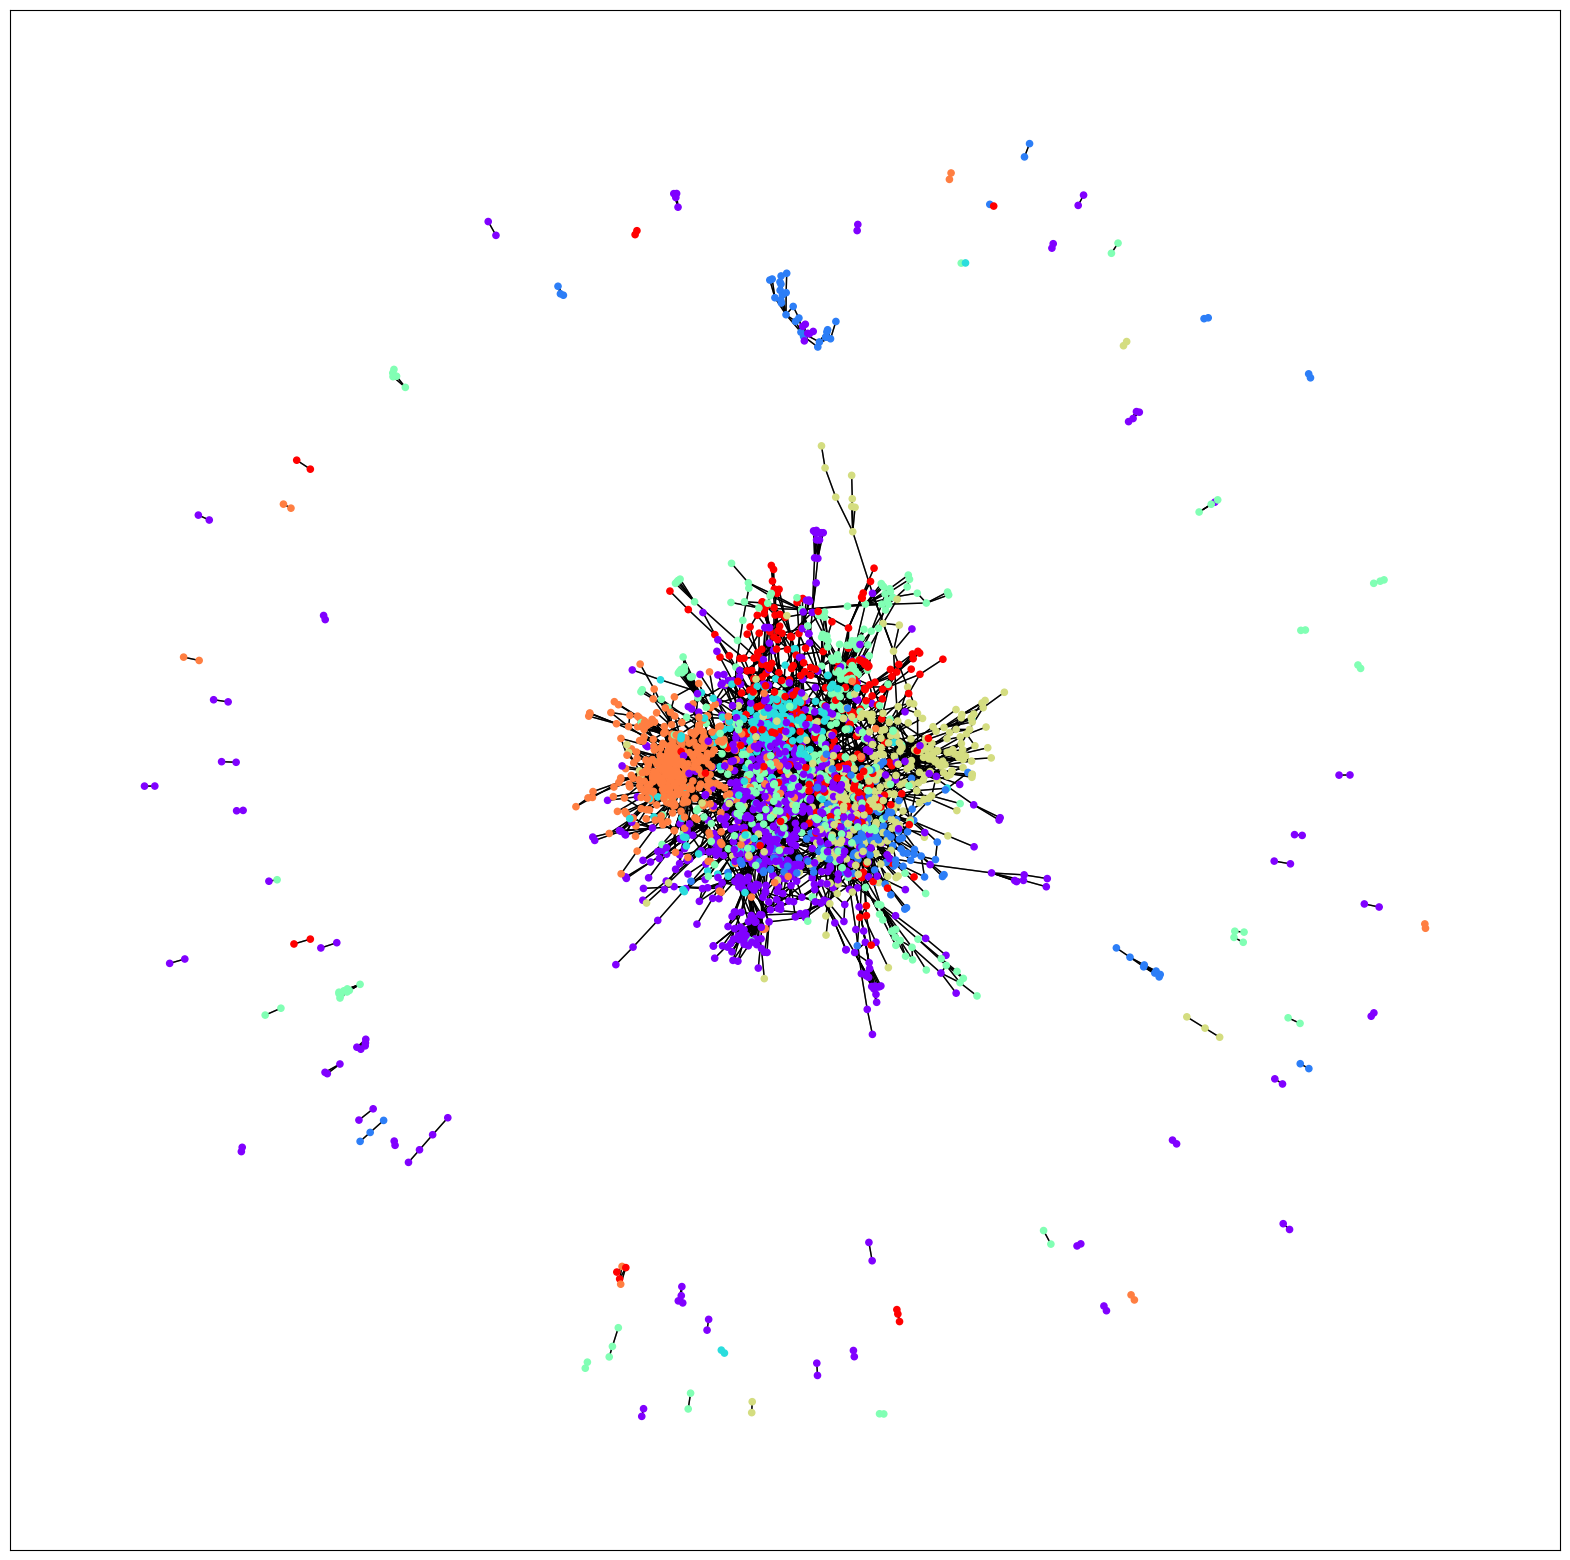

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_community(edges_path, memberships):
    G = nx.Graph()
    edges = np.loadtxt(edges_path, dtype=int)
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G)
    colors = [memberships[node] for node in G.nodes]
    
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_edges(G, pos, alpha=0.5)  # Explicitly draw edges
    nx.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
    plt.show()

edges_path = 'dataset/cora/edges.txt'
visualize_community(edges_path, y_pred_CDNMF)
visualize_community(edges_path, y_true)